# Tutorial of implementing Word2Vec
네이버 [김진중](https://github.com/golbin)님의 저서 **골빈해커의 3분 딥러닝 텐서플로맛**의 Word2Vec 예제코드를 OOP Style로 refactoring한 example
  
* Paper 
    * [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
    * [Distributed Representations of Words and Phrases
and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
* Reference
    * https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py
    * https://github.com/sjchoi86/Tensorflow-101/blob/master/notebooks/word2vec_simple.ipynb

### Setup

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

# matplot에서 한글을 표시하기위한 설정
font_name = matplotlib.font_manager.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf')
matplotlib.rc('font', family = font_name.get_name())
print(tf.__version__)
np.random.seed(777)
slim = tf.contrib.slim

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.6.0


### Prepare sentences and Preprocess

In [2]:
# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

In [3]:
# 문장을 전부 합친 후, 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = ' '.join(sentences).split()
word_list = list(set(word_sequence))
print(word_sequence)
print(word_list)

['나', '고양이', '좋다', '나', '강아지', '좋다', '나', '동물', '좋다', '강아지', '고양이', '동물', '여자친구', '고양이', '강아지', '좋다', '고양이', '생선', '우유', '좋다', '강아지', '생선', '싫다', '우유', '좋다', '강아지', '고양이', '눈', '좋다', '나', '여자친구', '좋다', '여자친구', '나', '싫다', '여자친구', '나', '영화', '책', '음악', '좋다', '나', '게임', '만화', '애니', '좋다', '고양이', '강아지', '싫다', '강아지', '고양이', '좋다']
['게임', '음악', '애니', '고양이', '책', '좋다', '우유', '눈', '만화', '생선', '동물', '싫다', '강아지', '영화', '나', '여자친구']


In [4]:
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dic = {w: i for i, w in enumerate(word_list)}
pprint(word_dic)

{'강아지': 12,
 '게임': 0,
 '고양이': 3,
 '나': 14,
 '눈': 7,
 '동물': 10,
 '만화': 8,
 '생선': 9,
 '싫다': 11,
 '애니': 2,
 '여자친구': 15,
 '영화': 13,
 '우유': 6,
 '음악': 1,
 '좋다': 5,
 '책': 4}


### Define preprocessor function for skip-gram of Word2Vec

In [5]:
def preprocessor(sequences, word_dic, window_size):
    context = []
    for idx in range(window_size, len(sequences) - window_size):
        center_word = word_dic.get(sequences[idx])
        context_words = [word_dic.get(sequences[idx + _]) for _ in range(-window_size, window_size + 1) if _ != 0]
    
        for token in context_words:
            context.append([center_word, token])
    else:
        return context

In [6]:
print([word_dic.get(_) for _ in word_sequence])

[14, 3, 5, 14, 12, 5, 14, 10, 5, 12, 3, 10, 15, 3, 12, 5, 3, 9, 6, 5, 12, 9, 11, 6, 5, 12, 3, 7, 5, 14, 15, 5, 15, 14, 11, 15, 14, 13, 4, 1, 5, 14, 0, 8, 2, 5, 3, 12, 11, 12, 3, 5]


In [7]:
tmp = preprocessor(sequences=word_sequence, word_dic=word_dic, window_size=1)
print(tmp)

[[3, 14], [3, 5], [5, 3], [5, 14], [14, 5], [14, 12], [12, 14], [12, 5], [5, 12], [5, 14], [14, 5], [14, 10], [10, 14], [10, 5], [5, 10], [5, 12], [12, 5], [12, 3], [3, 12], [3, 10], [10, 3], [10, 15], [15, 10], [15, 3], [3, 15], [3, 12], [12, 3], [12, 5], [5, 12], [5, 3], [3, 5], [3, 9], [9, 3], [9, 6], [6, 9], [6, 5], [5, 6], [5, 12], [12, 5], [12, 9], [9, 12], [9, 11], [11, 9], [11, 6], [6, 11], [6, 5], [5, 6], [5, 12], [12, 5], [12, 3], [3, 12], [3, 7], [7, 3], [7, 5], [5, 7], [5, 14], [14, 5], [14, 15], [15, 14], [15, 5], [5, 15], [5, 15], [15, 5], [15, 14], [14, 15], [14, 11], [11, 14], [11, 15], [15, 11], [15, 14], [14, 15], [14, 13], [13, 14], [13, 4], [4, 13], [4, 1], [1, 4], [1, 5], [5, 1], [5, 14], [14, 5], [14, 0], [0, 14], [0, 8], [8, 0], [8, 2], [2, 8], [2, 5], [5, 2], [5, 3], [3, 5], [3, 12], [12, 3], [12, 11], [11, 12], [11, 12], [12, 11], [12, 3], [3, 12], [3, 5]]


### Define Word2Vec class

In [8]:
class Word2Vec:
    def __init__(self, num_classes, embedding_dim = 2, num_sampled = 10):
        self._inputs = tf.placeholder(dtype = tf.int32, shape = [None])
        self._labels = tf.placeholder(dtype = tf.int32, shape = [None,1])

        # Look up embeddings for inputs.
        self._embeddings = tf.get_variable(name = 'embeddings_input', shape = [num_classes, embedding_dim],
                                     dtype = tf.float32, initializer = tf.truncated_normal_initializer())
        self._selected_embed = tf.nn.embedding_lookup(params = self._embeddings, ids = self._inputs)
            
        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(tf.random_uniform([num_classes, embedding_dim], -1.0, 1.0))
        nce_biases = tf.Variable(tf.zeros([num_classes]))
        
        # Compute the average NCE loss for the batch
        self._nce_loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, biases = nce_biases,
                                        labels = self._labels, inputs = self._selected_embed,
                                        num_sampled = num_sampled, num_classes = num_classes))
    
    def get_wordvector(self, sess, word_dic, word):
        idx = word_dic.get(word)
        feed_get_wordvector = {self._inputs : [idx]}
        return sess.run(self._selected_embed, feed_dict = feed_get_wordvector)

In [9]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._nce_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr):
        feed_train = {self._model._inputs : x_data, self._model._labels : y_data, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._nce_loss], feed_dict = feed_train)

### Training

In [10]:
print(word_dic)
print(word_sequence)

{'게임': 0, '음악': 1, '애니': 2, '고양이': 3, '책': 4, '좋다': 5, '우유': 6, '눈': 7, '만화': 8, '생선': 9, '동물': 10, '싫다': 11, '강아지': 12, '영화': 13, '나': 14, '여자친구': 15}
['나', '고양이', '좋다', '나', '강아지', '좋다', '나', '동물', '좋다', '강아지', '고양이', '동물', '여자친구', '고양이', '강아지', '좋다', '고양이', '생선', '우유', '좋다', '강아지', '생선', '싫다', '우유', '좋다', '강아지', '고양이', '눈', '좋다', '나', '여자친구', '좋다', '여자친구', '나', '싫다', '여자친구', '나', '영화', '책', '음악', '좋다', '나', '게임', '만화', '애니', '좋다', '고양이', '강아지', '싫다', '강아지', '고양이', '좋다']


In [11]:
batch = preprocessor(sequences = word_sequence, word_dic = word_dic, window_size = 2)
x_data = np.array(batch)[:,0]
y_data = np.array(batch)[:,[1]]

In [12]:
# generate Word2Vec instance, Solver instance
sess = tf.Session()
sgram = Word2Vec(num_classes = len(word_dic.keys()), embedding_dim = 2, num_sampled = 10)
adam_solver = Solver(model = sgram)

In [13]:
# hyper-parameter
epochs = 30
batch_size = 20
total_batch = int(x_data.shape[0] / batch_size)
print(total_batch)

9


In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
#training 
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    
    for step in range(total_batch):
        tr_indices = np.random.choice(np.arange(x_data.shape[0]), size = batch_size, replace = False)
        batch_xs = x_data[tr_indices]
        batch_ys = y_data[tr_indices]
        
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = .01)
        avg_tr_loss += tr_loss / total_batch
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch, avg_tr_loss))
    tr_loss_hist.append(avg_tr_loss)

epoch :   0, tr_loss : 10.306
epoch :   1, tr_loss : 9.960
epoch :   2, tr_loss : 9.442
epoch :   3, tr_loss : 8.703
epoch :   4, tr_loss : 8.402
epoch :   5, tr_loss : 7.949
epoch :   6, tr_loss : 7.722
epoch :   7, tr_loss : 6.643
epoch :   8, tr_loss : 6.268
epoch :   9, tr_loss : 5.667
epoch :  10, tr_loss : 5.469
epoch :  11, tr_loss : 4.941
epoch :  12, tr_loss : 4.483
epoch :  13, tr_loss : 4.637
epoch :  14, tr_loss : 3.751
epoch :  15, tr_loss : 3.753
epoch :  16, tr_loss : 3.419
epoch :  17, tr_loss : 3.397
epoch :  18, tr_loss : 3.398
epoch :  19, tr_loss : 3.348
epoch :  20, tr_loss : 3.177
epoch :  21, tr_loss : 3.025
epoch :  22, tr_loss : 3.124
epoch :  23, tr_loss : 3.112
epoch :  24, tr_loss : 3.073
epoch :  25, tr_loss : 2.805
epoch :  26, tr_loss : 2.978
epoch :  27, tr_loss : 3.072
epoch :  28, tr_loss : 2.961
epoch :  29, tr_loss : 2.908


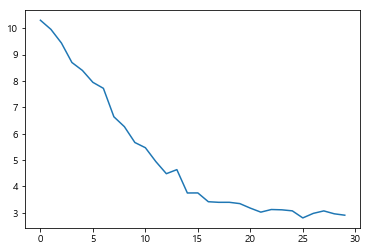

In [16]:
plt.plot(tr_loss_hist)

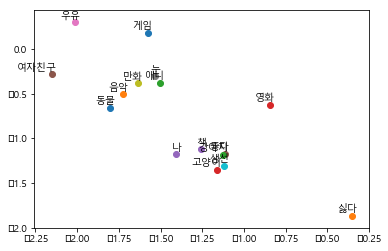

In [17]:
for word in word_list:
    tmp = sgram.get_wordvector(sess = sess, word_dic = word_dic, word = word)
    x, y = tmp[0][0], tmp[0][1]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')